# Problem: Predicting Airplane Delays

The goals of this notebook are:
- Process and create a dataset from downloaded ZIP files
- Exploratory data analysis (EDA)
- Establish a baseline model and improve it

## Introduction to business scenario
You work for a travel booking website that is working to improve the customer experience for flights that were delayed. The company wants to create a feature to let customers know if the flight will be delayed due to weather when the customers are booking the flight to or from the busiest airports for domestic travel in the US. 

You are tasked with solving part of this problem by leveraging machine learning to identify whether the flight will be delayed due to weather. You have been given access to the a dataset of on-time performance of domestic flights operated by large air carriers. You can use this data to train a machine learning model to predict if the flight is going to be delayed for the busiest airports.

### Dataset
The provided dataset contains scheduled and actual departure and arrival times reported by certified US air carriers that account for at least 1 percent of domestic scheduled passenger revenues. The data was collected by the Office of Airline Information, Bureau of Transportation Statistics (BTS). The dataset contains date, time, origin, destination, airline, distance, and delay status of flights for flights between 2014 and 2018.
The data are in 60 compressed files, where each file contains a CSV for the flight details in a month for the five years (from 2014 - 2018). The data can be downloaded from this link: [https://ucstaff-my.sharepoint.com/:f:/g/personal/ibrahim_radwan_canberra_edu_au/Er0nVreXmihEmtMz5qC5kVIB81-ugSusExPYdcyQTglfLg?e=bNO312]. Please download the data files and place them on a relative path. Dataset(s) used in this assignment were compiled by the Office of Airline Information, Bureau of Transportation Statistics (BTS), Airline On-Time Performance Data, available with the following link: [https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ]. 

# Step 1: Prepare the environment 

Use one of the labs which we have practised on with the Amazon Sagemakers where you perform the following steps:
1. Start a lab.
2. Create a notebook instance and name it "oncloudproject".
3. Increase the used memory to 25 GB from the additional configurations.
4. Open Jupyter Lab and upload this notebook into it.
5. Upload the two combined CVS files (combined_csv_v1.csv and combined_csv_v2.csv), which you created in Part A of this project.

# Step 2: Build and evaluate simple models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use linear learner estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 

Note: You are required to perform the above steps on the two combined datasets separatey and to comments on the difference.

In [3]:
#importing the required libraries
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import os
import io
import boto3
import re
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import sagemaker.amazon.common as smac

In [4]:
#reading the combined_csv_v1 dataset
dataset = pd.read_csv('combined_csv_v1.csv')
print(dataset.shape)
dataset[:5]

(1635590, 94)


target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
0     0.0     689.0          0          0          0        0        0   
1     0.0     731.0          0          0          0        0        0   
2     0.0    1199.0          0          0          0        0        0   
3     0.0    1587.0          0          0          0        0        0   
4     0.0    1587.0          0          0          0        0        0   

   Month_4  Month_5  Month_6  ...  DepHourofDay_14  DepHourofDay_15  \
0        0        0        0  ...                0                0   
1        0        0        0  ...                0                0   
2        0        0        0  ...                0                0   
3        0        0        0  ...                0                0   
4        0        0        0  ...                0                0   

   DepHourofDay_16  DepHourofDay_17  DepHourofDay_18  DepHourofDay_19  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                1                0   
3                1                0                0                0   
4                0                0                0                0   

   DepHourofDay_20  DepHourofDay_21  DepHourofDay_22  DepHourofDay_23  
0                0                1                0                0  
1                0                0                0                0  
2                0                0                0                0  
3                0                0                0                0  
4                0                0                0                0  

[5 rows x 94 columns]

In [72]:
#creating the linear learner model
linear_job = "DEMO-linear-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", linear_job)

linear_training_params = {
    "RoleArn": role,
    "TrainingJobName": linear_job,
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "ShardedByS3Key",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/".format(bucket, prefix)},
    "HyperParameters": {
        "feature_dim": "30",
        "mini_batch_size": "100",
        "predictor_type": "regressor",
        "epochs": "10",
        "num_models": "32",
        "loss": "absolute_loss",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 60 * 60},
}

Job name is: DEMO-linear-2021-11-12-05-13-54


In [5]:
#creating train, test and validation datasets from the loaded data 
import numpy as np
train, validate, test = \
              np.split(dataset.sample(frac=1, random_state=42), 
                       [int(.7*len(dataset)), int(.8*len(dataset))])

print(train.shape)
print(test.shape)
print(validate.shape)
train.to_csv('training_dataset.csv', index=False, header=False)
test.to_csv('testing_dataset.csv', index=False, header=False)
validate.to_csv('validation_dataset.csv', index=False, header=False)

(1144913, 94)
(327118, 94)
(163559, 94)


In [6]:
#importing the data
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'csv_v1'
training_data_path = sess.upload_data(path='training_dataset.csv', key_prefix=prefix + '/input/training')
testing_data_path = sess.upload_data(path='testing_dataset.csv', key_prefix=prefix + '/input/testing')
validation_data_path = sess.upload_data(path='validation_dataset.csv', key_prefix=prefix + '/input/validation')

print(training_data_path)
print(testing_data_path)
print(validation_data_path)

s3://sagemaker-us-east-1-724121841571/csv_v1/input/training/training_dataset.csv
s3://sagemaker-us-east-1-724121841571/csv_v1/input/testing/testing_dataset.csv
s3://sagemaker-us-east-1-724121841571/csv_v1/input/validation/validation_dataset.csv


In [7]:

import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri

from sagemaker import image_uris

container = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")
region = boto3.Session().region_name    
# container = get_image_uri(region, 'linear-learner')

from sagemaker.estimator import Estimator

role = sagemaker.get_execution_role() 

ll_estimator = Estimator(container,
    role=role, 
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)

ll_estimator.set_hyperparameters( predictor_type="binary_classifier", mini_batch_size=32,epochs = 5)

input_train = sagemaker.TrainingInput(s3_data=training_data_path, content_type='text/csv')
#input_test = sagemaker.TrainingInput(s3_data=testing_data_path, content_type='text/csv')
input_validate = sagemaker.TrainingInput(s3_data=validation_data_path, content_type='text/csv')

ll_data = {'train': input_train,'validation': input_validate}

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [9]:
#training the model
ll_estimator.fit(ll_data)

2021-11-12 05:35:30 Starting - Starting the training job...
2021-11-12 05:35:54 Starting - Launching requested ML instancesProfilerReport-1636695330: InProgress
.........
2021-11-12 05:37:24 Starting - Preparing the instances for training.........
2021-11-12 05:39:01 Downloading - Downloading input data......
2021-11-12 05:39:56 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/12/2021 05:40:13 INFO 140110500202304] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optim

In [10]:
%%bash -s "$ll_estimator.output_path"
aws s3 ls --recursive $1

2021-11-12 05:32:01     161475 csv_v1/output/linear-learner-2021-11-12-05-27-03-154/profiler-output/system/incremental/2021111205/1636695000.algo-1.json
2021-11-12 05:32:00     241974 csv_v1/output/linear-learner-2021-11-12-05-27-03-154/profiler-output/system/incremental/2021111205/1636695060.algo-1.json
2021-11-12 05:33:00     241862 csv_v1/output/linear-learner-2021-11-12-05-27-03-154/profiler-output/system/incremental/2021111205/1636695120.algo-1.json
2021-11-12 05:34:00     241870 csv_v1/output/linear-learner-2021-11-12-05-27-03-154/profiler-output/system/incremental/2021111205/1636695180.algo-1.json
2021-11-12 05:35:00     241843 csv_v1/output/linear-learner-2021-11-12-05-27-03-154/profiler-output/system/incremental/2021111205/1636695240.algo-1.json
2021-11-12 05:36:00     241905 csv_v1/output/linear-learner-2021-11-12-05-27-03-154/profiler-output/system/incremental/2021111205/1636695300.algo-1.json
2021-11-12 05:37:00     241878 csv_v1/output/linear-learner-2021-11-12-05-27-03-15

In [11]:
from time import strftime, gmtime
timestamp = strftime('%d-%H-%M-%S', gmtime())

endpoint_name = 'linear-learner-demo-'+timestamp
print(endpoint_name)

linear-learner-demo-12-08-11-40


In [12]:
#hosting the model
ll_predictor = ll_estimator.deploy(endpoint_name=endpoint_name, 
                        initial_instance_count=1, 
                        instance_type='ml.m4.xlarge')

------!

In [13]:
test_sample = test[:10]
test.shape

(327118, 94)

In [14]:
row = test.iloc[0:10,1:]
row

Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  Month_4  \
324117     1379.0          0          0          1        0        0        0   
1431831    1635.0          0          0          0        1        0        0   
331838      224.0          0          0          1        0        0        0   
1036083    2139.0          0          0          1        0        0        0   
621061      689.0          0          0          0        0        0        0   
633831     1235.0          0          0          1        0        0        0   
1097433     370.0          0          0          0        0        1        0   
1167310     606.0          1          0          0        0        0        0   
1374383     370.0          0          0          1        0        0        0   
12343      1440.0          0          0          0        0        0        0   

         Month_5  Month_6  Month_7  ...  DepHourofDay_14  DepHourofDay_15  \
324117         0        0        0  ...                0                0   
1431831        0        0        0  ...                0                0   
331838         0        0        0  ...                0                0   
1036083        0        0        0  ...                0                0   
621061         0        0        0  ...                0                0   
633831         0        0        0  ...                0                0   
1097433        0        0        0  ...                0                0   
1167310        1        0        0  ...                0                0   
1374383        0        0        0  ...                0                0   
12343          0        0        0  ...                0                0   

         DepHourofDay_16  DepHourofDay_17  DepHourofDay_18  DepHourofDay_19  \
324117                 0                0                0                0   
1431831                0                0                0                0   
331838                 0                0                0                0   
1036083                0                0                0                0   
621061                 0                0                1                0   
633831                 0                0                0                0   
1097433                0                0                0                0   
1167310                0                0                0                0   
1374383                0                0                0                0   
12343                  0                0                0                0   

         DepHourofDay_20  DepHourofDay_21  DepHourofDay_22  DepHourofDay_23  
324117                 0                0                0                0  
1431831                0                0                0                0  
331838                 0                0                0                0  
1036083                0                0                0                0  
621061                 0                0                0                0  
633831                 0                0                0                0  
1097433                0                0                1                0  
1167310                0                0                0                0  
1374383                0                0                0                0  
12343                  0                0                0                0  

[10 rows x 93 columns]

In [15]:
batch_X_csv_buffer = io.StringIO()
row.to_csv(batch_X_csv_buffer, header=False, index=False)
test_row = batch_X_csv_buffer.getvalue()
print(test_row)

1379.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1635.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
224.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2139.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
689.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1235.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

In [16]:
response = ll_predictor.predict(test_row)
print(response)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (415) from primary with message "content-type application/octet-stream not supported". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/linear-learner-demo-12-08-11-40 in account 724121841571 for more information.

## LINEAR LEARNER ESTIMATOR -- combined_csv_v2

In [19]:
#reading the dataset combined_csv_v2
dataset1 = pd.read_csv('combined_csv_v2.csv')
print(dataset1.shape)
dataset1[:5]

(1635590, 86)


target  Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  \
0     0.0     689.0            21      33       0    54.0      30       0   
1     0.0     731.0             9      39       0   136.0      33       0   
2     0.0    1199.0            18      33       0    54.0      77       0   
3     0.0    1587.0            16      33       0    54.0      20       0   
4     0.0    1587.0             7      20       0   165.0      33       0   

   TAVG_D  SNOW_O  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  \
0   130.0     0.0  ...           0         0         0         0         1   
1    54.0     0.0  ...           0         0         0         0         0   
2    68.0     0.0  ...           0         0         1         0         0   
3   165.0     0.0  ...           0         0         0         0         0   
4    54.0     0.0  ...           0         0         0         0         0   

   Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_1  
0         0         0         0         0             0  
1         0         0         0         0             0  
2         0         0         0         0             0  
3         0         0         1         0             0  
4         0         0         0         0             0  

[5 rows x 86 columns]

In [20]:
#creating linear learner model
linear_job = "DEMO-linear-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", linear_job)

linear_training_params = {
    "RoleArn": role,
    "TrainingJobName": linear_job,
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "ShardedByS3Key",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/".format(bucket, prefix)},
    "HyperParameters": {
        "feature_dim": "30",
        "mini_batch_size": "100",
        "predictor_type": "regressor",
        "epochs": "10",
        "num_models": "32",
        "loss": "absolute_loss",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 60 * 60},
}

Job name is: DEMO-linear-2021-11-12-08-24-31


In [29]:
#preparing training,test and validation datasets
import numpy as np
train1, validate1, test1 = \
              np.split(dataset1.sample(frac=1, random_state=42), 
                       [int(.7*len(dataset1)), int(.8*len(dataset1))])

print(train1.shape)
print(test1.shape)
print(validate1.shape)
train1.to_csv('training_dataset1.csv', index=False, header=False)
#test.to_csv('testing_dataset1.csv', index=False, header=False)
validate1.to_csv('validation_dataset1.csv', index=False, header=False)

(1144913, 86)
(327118, 86)
(163559, 86)


In [30]:
#uploading the data
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'csv_v2'
training_data_path1 = sess.upload_data(path='training_dataset1.csv', key_prefix=prefix + '/input/training')
#testing_data_path1 = sess.upload_data(path='testing_dataset1.csv', key_prefix=prefix + '/input/testing')
validation_data_path1 = sess.upload_data(path='validation_dataset1.csv', key_prefix=prefix + '/input/validation')

print(training_data_path1)
#print(testing_data_path1)
print(validation_data_path1)

s3://sagemaker-us-east-1-724121841571/csv_v2/input/training/training_dataset1.csv
s3://sagemaker-us-east-1-724121841571/csv_v2/input/validation/validation_dataset1.csv


In [31]:
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri

from sagemaker import image_uris

container = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")
region = boto3.Session().region_name    
# container = get_image_uri(region, 'linear-learner')

from sagemaker.estimator import Estimator

role = sagemaker.get_execution_role() 

ll_estimator = Estimator(container,
    role=role, 
    train_instance_count=1,
    train_instance_type='ml.m4.xlarge',
    output_path='s3://{}/{}/output'.format(bucket, prefix)
)

ll_estimator.set_hyperparameters( predictor_type="binary_classifier", mini_batch_size=32,epochs = 5)

input_train1 = sagemaker.TrainingInput(s3_data=training_data_path1, content_type='text/csv')
input_validate1 = sagemaker.TrainingInput(s3_data=validation_data_path1, content_type='text/csv')




ll_data1 = {'train': input_train1,'validation': input_validate1}

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [ ]:
#training the model
ll_estimator.fit(ll_data1)

2021-11-12 09:48:49 Starting - Starting the training job...
2021-11-12 09:49:17 Starting - Launching requested ML instancesProfilerReport-1636710529: InProgress
......
2021-11-12 09:50:17 Starting - Preparing the instances for training............
2021-11-12 09:52:18 Downloading - Downloading input data...
2021-11-12 09:52:43 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/12/2021 09:52:47 INFO 140310196840256] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init

In [ ]:
%%bash -s "$ll_estimator.output_path"
aws s3 ls --recursive $1

In [ ]:
from time import strftime, gmtime
timestamp = strftime('%d-%H-%M-%S', gmtime())

endpoint_name = 'linear-learner-demo-'+timestamp
print(endpoint_name)

In [ ]:
#hosting the model
ll_predictor = ll_estimator.deploy(endpoint_name=endpoint_name, 
                        initial_instance_count=1, 
                        instance_type='ml.m4.xlarge')

In [ ]:
# Write the final comments here and turn the cell type into markdown

# Step 3: Build and evaluate ensembe models

Write code to perform the follwoing steps:
1. Split data into training, validation and testing sets (70% - 15% - 15%).
2. Use xgboost estimator to build a classifcation model.
3. Host the model on another instance
4. Perform batch transform to evaluate the model on testing data
5. Report the performance metrics that you see better test the model performance 
6. write down your observation on the difference between the performance of using the simple and ensemble models.
Note: You are required to perform the above steps on the two combined datasets separatey.

In [1]:
#reading the dataset combined sv v2
import pandas as pd
df = pd.read_csv('combined_csv_v2.csv')
print(df.shape)
df[:5]

(1635590, 86)


target  Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  \
0     0.0     689.0            21      33       0    54.0      30       0   
1     0.0     731.0             9      39       0   136.0      33       0   
2     0.0    1199.0            18      33       0    54.0      77       0   
3     0.0    1587.0            16      33       0    54.0      20       0   
4     0.0    1587.0             7      20       0   165.0      33       0   

   TAVG_D  SNOW_O  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  \
0   130.0     0.0  ...           0         0         0         0         1   
1    54.0     0.0  ...           0         0         0         0         0   
2    68.0     0.0  ...           0         0         1         0         0   
3   165.0     0.0  ...           0         0         0         0         0   
4    54.0     0.0  ...           0         0         0         0         0   

   Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_1  
0         0         0         0         0             0  
1         0         0         0         0             0  
2         0         0         0         0             0  
3         0         0         1         0             0  
4         0         0         0         0             0  

[5 rows x 86 columns]

In [2]:
#preparing test train and validation datasets
import numpy as np
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.7*len(df)), int(.8*len(df))])

print(train.shape)
print(test.shape)
print(validate.shape)
train.to_csv('training_dataset.csv', index=False, header=False)
test.to_csv('testing_dataset.csv', index=False, header=False)
validate.to_csv('validation_dataset.csv', index=False, header=False)

(1144913, 86)
(327118, 86)
(163559, 86)


In [4]:
#uploading the data Convert the Train and Validation Datasets to CSV Files
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'csv_v2'
training_data_path = sess.upload_data(path='training_dataset.csv', key_prefix=prefix + '/input/training')
testing_data_path = sess.upload_data(path='testing_dataset.csv', key_prefix=prefix + '/input/testing')
validation_data_path = sess.upload_data(path='validation_dataset.csv', key_prefix=prefix + '/input/validation')

print(training_data_path)
print(testing_data_path)
print(validation_data_path)

s3://sagemaker-us-east-1-724121841571/csv_v2/input/training/training_dataset.csv
s3://sagemaker-us-east-1-724121841571/csv_v2/input/testing/testing_dataset.csv
s3://sagemaker-us-east-1-724121841571/csv_v2/input/validation/validation_dataset.csv


In [5]:
#Upload the Datasets and Create and Run a Training Job
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
from sagemaker.estimator import Estimator


 region = boto3.Session().region_name    
container = get_image_uri(region, 'xgboost', repo_version='1.0-1')
role = sagemaker.get_execution_role() 

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sagemaker.Session(),
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
)

xgb_model.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "binary:logistic",
    num_round = 200
)


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1


In [8]:
#uploading the data and model training
from sagemaker.session import TrainingInput
training_data_channel   = sagemaker.TrainingInput(s3_data=training_data_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=validation_data_path, content_type='text/csv')

# xgb_model = {'train': training_data_channel, 'validation': validation_data_channel, wait=True}
xgb_model.fit({"train": training_data_channel, "validation": validation_data_channel}, wait=True)

2021-11-12 03:46:25 Starting - Starting the training job...
2021-11-12 03:46:27 Starting - Launching requested ML instancesCreateXgboostReport: InProgress
ProfilerReport-1636688785: InProgress
...........................
2021-11-12 03:51:18 Starting - Preparing the instances for training............
2021-11-12 03:53:18 Downloading - Downloading input data...
2021-11-12 03:53:59 Training - Downloading the training image...
2021-11-12 03:54:22 Training - Training image download completed. Training in progress..[2021-11-12 03:54:24.376 ip-10-0-220-61.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:D

In [9]:
rule_output_path = xgb_model.output_path + "/" + xgb_model.latest_training_job.name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive

2021-11-12 04:02:17        321 csv_v2/output/sagemaker-xgboost-2021-11-12-03-46-25-464/rule-output/CreateXgboostReport/xgboost-reports/ConfusionMatrix.json
2021-11-12 04:02:17        734 csv_v2/output/sagemaker-xgboost-2021-11-12-03-46-25-464/rule-output/CreateXgboostReport/xgboost-reports/EvaluationMetrics.json
2021-11-12 04:02:17      18638 csv_v2/output/sagemaker-xgboost-2021-11-12-03-46-25-464/rule-output/CreateXgboostReport/xgboost-reports/FeatureImportance.json
2021-11-12 04:02:17       1974 csv_v2/output/sagemaker-xgboost-2021-11-12-03-46-25-464/rule-output/CreateXgboostReport/xgboost-reports/IterativeClassAccuracy.json
2021-11-12 04:02:17        182 csv_v2/output/sagemaker-xgboost-2021-11-12-03-46-25-464/rule-output/CreateXgboostReport/xgboost-reports/LabelsDistribution.json
2021-11-12 04:02:17       7223 csv_v2/output/sagemaker-xgboost-2021-11-12-03-46-25-464/rule-output/CreateXgboostReport/xgboost-reports/LossData.json
2021-11-12 04:02:18    3528464 csv_v2/output/sagemaker-xg

In [10]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-724121841571/csv_v2/output/sagemaker-xgboost-2021-11-12-03-46-25-464/rule-output/CreateXgboostReport/xgboost-reports/FeatureImportance.json to CreateXgboostReport/xgboost-reports/FeatureImportance.json
download: s3://sagemaker-us-east-1-724121841571/csv_v2/output/sagemaker-xgboost-2021-11-12-03-46-25-464/rule-output/CreateXgboostReport/xgboost-reports/ConfusionMatrix.json to CreateXgboostReport/xgboost-reports/ConfusionMatrix.json
download: s3://sagemaker-us-east-1-724121841571/csv_v2/output/sagemaker-xgboost-2021-11-12-03-46-25-464/rule-output/CreateXgboostReport/xgboost-reports/EvaluationMetrics.json to CreateXgboostReport/xgboost-reports/EvaluationMetrics.json
download: s3://sagemaker-us-east-1-724121841571/csv_v2/output/sagemaker-xgboost-2021-11-12-03-46-25-464/rule-output/CreateXgboostReport/xgboost-reports/LabelsDistribution.json to CreateXgboostReport/xgboost-reports/LabelsDistribution.json
download: s3://sagemaker-us-east-1-724121841571/csv_v2

In [11]:
#printing the training report
from IPython.display import FileLink, FileLinks
display("Click link below to view the XGBoost Training report", FileLink("CreateXgboostReport/xgboost_report.html"))

'Click link below to view the XGBoost Training report'

/home/ec2-user/SageMaker/CreateXgboostReport/xgboost_report.html

In [13]:
xgb_model.model_data

's3://sagemaker-us-east-1-724121841571/csv_v2/output/sagemaker-xgboost-2021-11-12-03-46-25-464/output/model.tar.gz'

In [14]:
#hosting the model
import sagemaker
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    serializer=CSVSerializer()
)

-----------!

In [15]:
xgb_predictor.endpoint_name

'sagemaker-xgboost-2021-11-12-04-05-13-562'

In [16]:
import sagemaker
xgb_predictor_reuse=sagemaker.predictor.Predictor(
    endpoint_name="sagemaker-xgboost-YYYY-MM-DD-HH-MM-SS-SSS",
    sagemaker_session=sagemaker.Session(),
    serializer=sagemaker.serializers.CSVSerializer()
)

In [18]:
import os
test.to_csv('test_v2.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'test/test.csv')).upload_file('test_v2.csv')


In [19]:
# The location of the test dataset
batch_input = 's3://{}/{}/test'.format(bucket, prefix)

# The location to store the results of the batch transform job
batch_output = 's3://{}/{}/batch-prediction'.format(bucket, prefix)

In [20]:
transformer = xgb_model.transformer(
    instance_count=1, 
    instance_type='ml.m4.xlarge', 
    output_path=batch_output
)

In [22]:
! aws s3 cp {batch_output} ./ --recursive

In [23]:
#defining funciton to predict the test data
import numpy as np
def predict(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

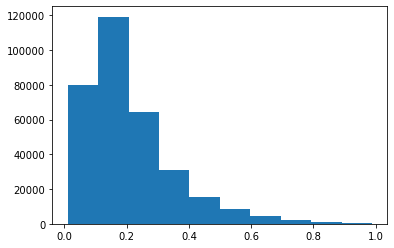

In [24]:
#histogram of predictions
import matplotlib.pyplot as plt

predictions=predict(test.to_numpy()[:,1:])
plt.hist(predictions)
plt.show()

In [26]:
#evaluation metrics
from sklearn.metrics import confusion_matrix
cutoff=0.5
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

#the accuracy of xgb model for combined_csv_v2 is 81%

[[253127   5583]
 [ 57352  11056]]
              precision    recall  f1-score   support

         0.0       0.82      0.98      0.89    258710
         1.0       0.66      0.16      0.26     68408

    accuracy                           0.81    327118
   macro avg       0.74      0.57      0.57    327118
weighted avg       0.78      0.81      0.76    327118



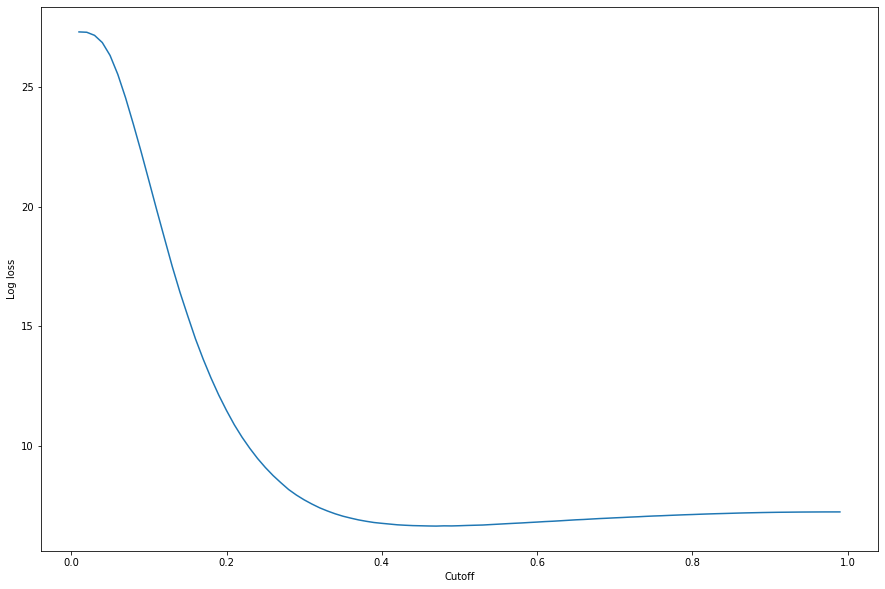

In [27]:

import matplotlib.pyplot as plt

cutoffs = np.arange(0.01, 1, 0.01)
log_loss = []
for c in cutoffs:
    log_loss.append(
        sklearn.metrics.log_loss(test.iloc[:, 0], np.where(predictions > c, 1, 0))
    )

plt.figure(figsize=(15,10))
plt.plot(cutoffs, log_loss)
plt.xlabel("Cutoff")
plt.ylabel("Log loss")
plt.show()

In [28]:
print(
    'Log loss is minimized at a cutoff of ', cutoffs[np.argmin(log_loss)], 
    ', and the log loss value at the minimum is ', np.min(log_loss)
)

Log loss is minimized at a cutoff of  0.47000000000000003 , and the log loss value at the minimum is  6.629387763835232


## XGBOOST ESTIMATOR - combined_csv_v1

In [29]:
#importing the data
import pandas as pd
df1 = pd.read_csv('combined_csv_v1.csv')
print(df1.shape)
df[:5]

(1635590, 94)


target  Distance  DepHourofDay  AWND_O  PRCP_O  TAVG_O  AWND_D  PRCP_D  \
0     0.0     689.0            21      33       0    54.0      30       0   
1     0.0     731.0             9      39       0   136.0      33       0   
2     0.0    1199.0            18      33       0    54.0      77       0   
3     0.0    1587.0            16      33       0    54.0      20       0   
4     0.0    1587.0             7      20       0   165.0      33       0   

   TAVG_D  SNOW_O  ...  Origin_SFO  Dest_CLT  Dest_DEN  Dest_DFW  Dest_IAH  \
0   130.0     0.0  ...           0         0         0         0         1   
1    54.0     0.0  ...           0         0         0         0         0   
2    68.0     0.0  ...           0         0         1         0         0   
3   165.0     0.0  ...           0         0         0         0         0   
4    54.0     0.0  ...           0         0         0         0         0   

   Dest_LAX  Dest_ORD  Dest_PHX  Dest_SFO  is_holiday_1  
0         0         0         0         0             0  
1         0         0         0         0             0  
2         0         0         0         0             0  
3         0         0         1         0             0  
4         0         0         0         0             0  

[5 rows x 86 columns]

In [30]:
#dividing the data into train,test and validation datasets 
import numpy as np
train, validate, test = \
              np.split(df1.sample(frac=1, random_state=42), 
                       [int(.7*len(df1)), int(.8*len(df1))])

print(train.shape)
print(test.shape)
print(validate.shape)
train.to_csv('training_dataset.csv', index=False, header=False)
test.to_csv('testing_dataset.csv', index=False, header=False)
validate.to_csv('validation_dataset.csv', index=False, header=False)

(1144913, 94)
(327118, 94)
(163559, 94)


In [31]:
#uploading the data
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'csv_v1'
training_data_path = sess.upload_data(path='training_dataset.csv', key_prefix=prefix + '/input/training')
testing_data_path = sess.upload_data(path='testing_dataset.csv', key_prefix=prefix + '/input/testing')
validation_data_path = sess.upload_data(path='validation_dataset.csv', key_prefix=prefix + '/input/validation')

print(training_data_path)
print(testing_data_path)
print(validation_data_path)

s3://sagemaker-us-east-1-724121841571/csv_v1/input/training/training_dataset.csv
s3://sagemaker-us-east-1-724121841571/csv_v1/input/testing/testing_dataset.csv
s3://sagemaker-us-east-1-724121841571/csv_v1/input/validation/validation_dataset.csv


In [33]:
##uploading the data Convert the Train and Validation Datasets to CSV Files
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.debugger import Rule, rule_configs
from sagemaker.session import TrainingInput
from sagemaker.estimator import Estimator


region = boto3.Session().region_name    
container = get_image_uri(region, 'xgboost', repo_version='1.0-1')
role = sagemaker.get_execution_role() 

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path='s3://{}/{}/output'.format(bucket, prefix),
    sagemaker_session=sagemaker.Session(),
    rules=[Rule.sagemaker(rule_configs.create_xgboost_report())]
)

xgb_model.set_hyperparameters(
    max_depth = 5,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "binary:logistic",
    num_round = 200
)


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1


In [34]:
#uploading the data
from sagemaker.session import TrainingInput
training_data_channel   = sagemaker.TrainingInput(s3_data=training_data_path, content_type='text/csv')
validation_data_channel = sagemaker.TrainingInput(s3_data=validation_data_path, content_type='text/csv')

# xgb_model = {'train': training_data_channel, 'validation': validation_data_channel, wait=True}
xgb_model.fit({"train": training_data_channel, "validation": validation_data_channel}, wait=True)

2021-11-12 04:32:39 Starting - Starting the training job...
2021-11-12 04:32:55 Starting - Launching requested ML instancesCreateXgboostReport: InProgress
ProfilerReport-1636691559: InProgress
.........
2021-11-12 04:34:38 Starting - Preparing the instances for training.........
2021-11-12 04:36:08 Downloading - Downloading input data......
2021-11-12 04:36:59 Training - Downloading the training image..[2021-11-12 04:37:20.763 ip-10-0-198-186.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determ

In [35]:
rule_output_path = xgb_model.output_path + "/" + xgb_model.latest_training_job.name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive

2021-11-12 04:45:09        318 csv_v1/output/sagemaker-xgboost-2021-11-12-04-32-39-165/rule-output/CreateXgboostReport/xgboost-reports/ConfusionMatrix.json
2021-11-12 04:45:09        733 csv_v1/output/sagemaker-xgboost-2021-11-12-04-32-39-165/rule-output/CreateXgboostReport/xgboost-reports/EvaluationMetrics.json
2021-11-12 04:45:09      19959 csv_v1/output/sagemaker-xgboost-2021-11-12-04-32-39-165/rule-output/CreateXgboostReport/xgboost-reports/FeatureImportance.json
2021-11-12 04:45:09       1953 csv_v1/output/sagemaker-xgboost-2021-11-12-04-32-39-165/rule-output/CreateXgboostReport/xgboost-reports/IterativeClassAccuracy.json
2021-11-12 04:45:09        182 csv_v1/output/sagemaker-xgboost-2021-11-12-04-32-39-165/rule-output/CreateXgboostReport/xgboost-reports/LabelsDistribution.json
2021-11-12 04:45:09       7216 csv_v1/output/sagemaker-xgboost-2021-11-12-04-32-39-165/rule-output/CreateXgboostReport/xgboost-reports/LossData.json
2021-11-12 04:45:10    3757808 csv_v1/output/sagemaker-xg

In [36]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-724121841571/csv_v1/output/sagemaker-xgboost-2021-11-12-04-32-39-165/rule-output/CreateXgboostReport/xgboost-reports/ConfusionMatrix.json to CreateXgboostReport/xgboost-reports/ConfusionMatrix.json
download: s3://sagemaker-us-east-1-724121841571/csv_v1/output/sagemaker-xgboost-2021-11-12-04-32-39-165/rule-output/CreateXgboostReport/xgboost-reports/IterativeClassAccuracy.json to CreateXgboostReport/xgboost-reports/IterativeClassAccuracy.json
download: s3://sagemaker-us-east-1-724121841571/csv_v1/output/sagemaker-xgboost-2021-11-12-04-32-39-165/rule-output/CreateXgboostReport/xgboost-reports/FeatureImportance.json to CreateXgboostReport/xgboost-reports/FeatureImportance.json
download: s3://sagemaker-us-east-1-724121841571/csv_v1/output/sagemaker-xgboost-2021-11-12-04-32-39-165/rule-output/CreateXgboostReport/xgboost-reports/EvaluationMetrics.json to CreateXgboostReport/xgboost-reports/EvaluationMetrics.json
download: s3://sagemaker-us-east-1-72412184157

In [37]:
#creating the training report
from IPython.display import FileLink, FileLinks
display("Click link below to view the XGBoost Training report", FileLink("CreateXgboostReport/xgboost_report.html"))

'Click link below to view the XGBoost Training report'

/home/ec2-user/SageMaker/CreateXgboostReport/xgboost_report.html

In [38]:
xgb_model.model_data

's3://sagemaker-us-east-1-724121841571/csv_v1/output/sagemaker-xgboost-2021-11-12-04-32-39-165/output/model.tar.gz'

In [39]:
#hosting the model
import sagemaker
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    serializer=CSVSerializer()
)

---------!

In [40]:
xgb_predictor.endpoint_name

'sagemaker-xgboost-2021-11-12-04-45-46-007'

In [41]:
import sagemaker
xgb_predictor_reuse=sagemaker.predictor.Predictor(
    endpoint_name="sagemaker-xgboost-YYYY-MM-DD-HH-MM-SS-SSS",
    sagemaker_session=sagemaker.Session(),
    serializer=sagemaker.serializers.CSVSerializer()
)

In [42]:
import os
test.to_csv('test_v2.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'test/test.csv')).upload_file('test_v2.csv')


In [43]:
# The location of the test dataset
batch_input = 's3://{}/{}/test'.format(bucket, prefix)

# The location to store the results of the batch transform job
batch_output = 's3://{}/{}/batch-prediction'.format(bucket, prefix)

In [44]:
transformer = xgb_model.transformer(
    instance_count=1, 
    instance_type='ml.m4.xlarge', 
    output_path=batch_output
)

In [47]:
test.shape

(327118, 94)

In [58]:
import numpy as np
def predict(data, rows=10000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

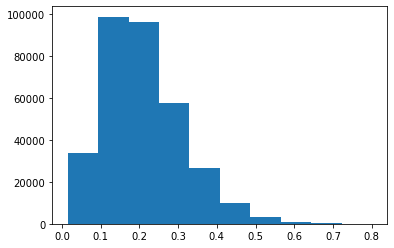

In [59]:
import matplotlib.pyplot as plt

predictions=predict(test.to_numpy()[:,1:])
plt.hist(predictions)
plt.show()

In [60]:
from sklearn.metrics import confusion_matrix
cutoff=0.5
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))


[[257417   1293]
 [ 66116   2292]]
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.88    258710
         1.0       0.64      0.03      0.06     68408

    accuracy                           0.79    327118
   macro avg       0.72      0.51      0.47    327118
weighted avg       0.76      0.79      0.71    327118



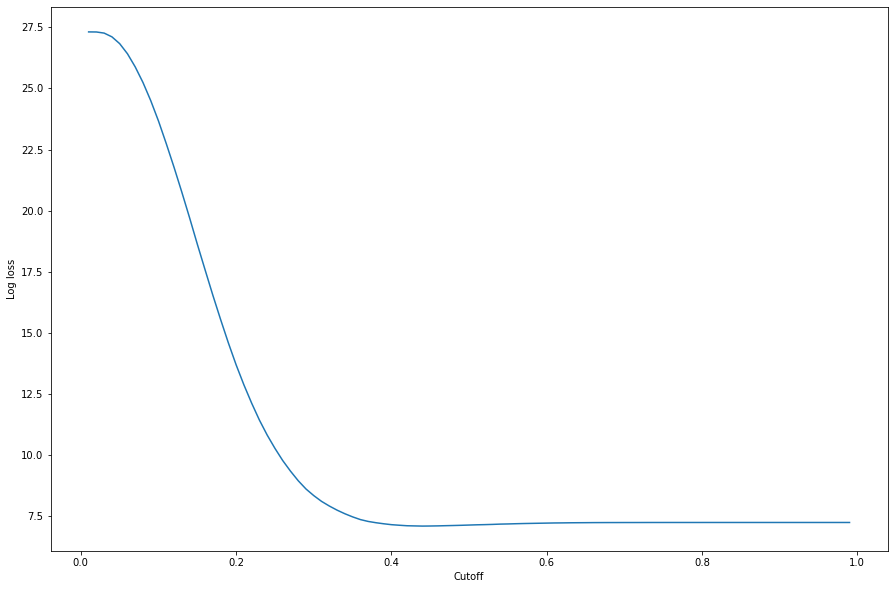

In [61]:
import matplotlib.pyplot as plt

cutoffs = np.arange(0.01, 1, 0.01)
log_loss = []
for c in cutoffs:
    log_loss.append(
        sklearn.metrics.log_loss(test.iloc[:, 0], np.where(predictions > c, 1, 0))
    )

plt.figure(figsize=(15,10))
plt.plot(cutoffs, log_loss)
plt.xlabel("Cutoff")
plt.ylabel("Log loss")
plt.show()

In [62]:
print(
    'Log loss is minimized at a cutoff of ', cutoffs[np.argmin(log_loss)], 
    ', and the log loss value at the minimum is ', np.min(log_loss)
)

Log loss is minimized at a cutoff of  0.44 , and the log loss value at the minimum is  7.074842345554985


The xgb model accuracy for combined_Csv_file_V1 is 0.79 the xgb model accuracy for combined_Csv_file_V2 is 0.81 which can be seen that
model for csv file v2 is better i.e the featured engineered dataset is better as per the XGB model